## Federated Learning using Boston Housing dataset

In [1]:
%matplotlib inline

import sys
import os
helpers_path = os.path.abspath('../')
if helpers_path not in sys.path:
    sys.path.append(helpers_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from data.datasets import load_dodd

from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from federatedLearning import fl_sync, fl_async, cent_learn

# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

from sklearn.datasets import fetch_california_housing, load_boston
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

Number of processors:  8


In [296]:
kernel = Kernel(6)

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100,1000,2000]
iteration = 30000
num_experiments = 3

(506, 13)
(506,)


In [325]:
kernel = Kernel(6)
K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100,1000,2000]
iteration = 30000
num_experiments = 3

step_size = 0.9
KLMS_RFF = klms_rff(step_size,D)
KLMS_RFF_cent = klms_rff(0.09,D)
amse_KLMS = []
for l in L:
    amse = np.zeros(iteration)
    amse_KLMS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)

        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KLMS_RFF,u,d)
        amse += mse/num_experiments
    amse_KLMS.append(amse)

100%|█████████████████████████████████████████████| 3/3 [00:07<00:00,  2.52s/it]


In [382]:
kernel = Kernel(6)

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100,1000,2000]
iteration = 30000
num_experiments = 3

step_size = 0.9
reg_coeff = 0.009
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KNLMS_RFF_cent = knlms_rff(0.09,reg_coeff,D)
amse_KNLMS = []
for l in L:
    amse = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)

        mse_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KNLMS_RFF,u,d)
        amse += mse/num_experiments
    amse_KNLMS.append(amse)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/cjfelix/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target 

In [378]:
kernel = Kernel(6)

# Federated learning: Synchronous updating rule

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100,1000,2000]
iteration = 30000
num_experiments = 3

KRLS_RFF = krls_rff(D,beta=0.08)
KRLS_RFF_cent = krls_rff(D,beta=1.0)
amse_KRLS = []
for l in L:
    amse = np.zeros(iteration)
    amse_KRLS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLsync = fl_sync(K,h,l)

        mse_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_cent/num_experiments
        mse = FLsync.train(iteration,KRLS_RFF,u,d)
        amse += mse/num_experiments
    amse_KRLS.append(amse)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/cjfelix/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target 

Text(0.5, 0, 'iteration')

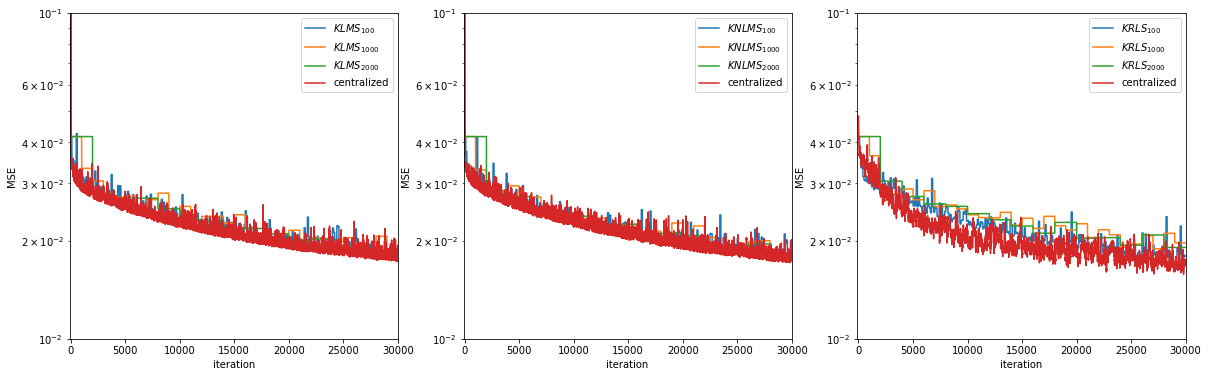

In [384]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1,3,1)
for i in range(len(amse_KLMS)):
    plt.semilogy(range(len(amse_KLMS[i])),amse_KLMS[i],label="$KLMS_{" + str(L[i])+"}$")
# amse_cent = np.convolve(amse_cent,np.ones(200)/200,'valid')    
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1,3,2)
for i in range(len(amse_KNLMS)):
    plt.semilogy(range(len(amse_KNLMS[i])),amse_KNLMS[i],label="$KNLMS_{" + str(L[i])+"}$")
# amse_cent = np.convolve(amse_cent,np.ones(200)/200,'valid')    
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1,3,3)
for i in range(len(amse_KRLS)):
    plt.semilogy(range(len(amse_KRLS[i])),amse_KRLS[i],label="$KRLS_{" + str(L[i])+"}$")
amse_cent_KRLS_smooth = np.convolve(amse_KRLS_cent,np.ones(60)/60,'valid')    
plt.semilogy(range(len(amse_cent_KRLS_smooth)),amse_cent_KRLS_smooth,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")

In [375]:
print(amse_KRLS[2])
print(amse_KLMS[2])
print(amse_KNLMS[2])

[0.04168867 0.04168867 0.04168867 ... 0.01892293 0.01892293 0.01892293]
[0.04168867 0.04168867 0.04168867 ... 0.01827399 0.01827399 0.01827399]
[0.04168867 0.04168867 0.04168867 ... 0.02038922 0.02038922 0.02038922]


In [301]:
print(amse_KLMS[0][3000-10:3000])
print(amse_cent[3000-10:3000])

[0.02974572 0.02974572 0.02974572 0.02974572 0.02974572 0.02974572
 0.02974572 0.02974572 0.02974572 0.02974572]
[0.07040963 0.03101389 0.02703273 0.02899715 0.02616679 0.02617814
 0.02477164 0.02606751 0.02560188 0.02338662]


In [385]:
kernel = Kernel(6)
K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
P = [10,30,50]
iteration = 30000
num_experiments = 3

step_size = 0.9
KLMS_RFF = klms_rff(step_size,D)
KLMS_RFF_cent = klms_rff(0.09,D)
amse_KLMS = []
for p in P:
    amse = np.zeros(iteration)
    amse_KLMS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLasync = fl_async(K,h,p)

        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_KLMS_cent += mse_cent/num_experiments
        mse = FLasync.train(iteration,KLMS_RFF,u,d)
        amse += mse/num_experiments
    amse_KLMS.append(amse)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/cjfelix/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target 

In [390]:
kernel = Kernel(6)

# Federated learning: Synchronous updating rule

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
L = [100,1000,2000]
iteration = 30000
num_experiments = 3

step_size = 0.9
reg_coeff = 0.009
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KNLMS_RFF_cent = knlms_rff(0.09,reg_coeff,D)
amse_KNLMS = []
for p in P:
    amse = np.zeros(iteration)
    amse_KNLMS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLasync = fl_async(K,h,p)

        mse_cent = cent_learn(iteration,K,KNLMS_RFF_cent,h,u,d)
        amse_KNLMS_cent += mse_cent/num_experiments
        mse = FLasync.train(iteration,KNLMS_RFF,u,d)
        amse += mse/num_experiments
    amse_KNLMS.append(amse)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/cjfelix/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target 

In [391]:
kernel = Kernel(6)

# Federated learning: Synchronous updating rule

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 100 # Dictionary size
P = [10,30,50]
iteration = 30000
num_experiments = 3

KRLS_RFF = krls_rff(D,beta=0.08)
KRLS_RFF_cent = krls_rff(D,beta=1.0)
amse_KRLS = []
for p in P:
    amse = np.zeros(iteration)
    amse_KRLS_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):
        u,d = load_boston(return_X_y=True)
        u,d = shuffle(u, d)
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        d = (d-np.min(d))/(np.max(d)-np.min(d))
        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(13,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        FLasync = fl_async(K,h,p)

        mse_cent = cent_learn(iteration,K,KRLS_RFF_cent,h,u,d)
        amse_KRLS_cent += mse_cent/num_experiments
        mse = FLasync.train(iteration,KRLS_RFF,u,d)
        amse += mse/num_experiments
    amse_KRLS.append(amse)

100%|█████████████████████████████████████████████| 3/3 [00:17<00:00,  5.79s/it]


Text(0.5, 0, 'iteration')

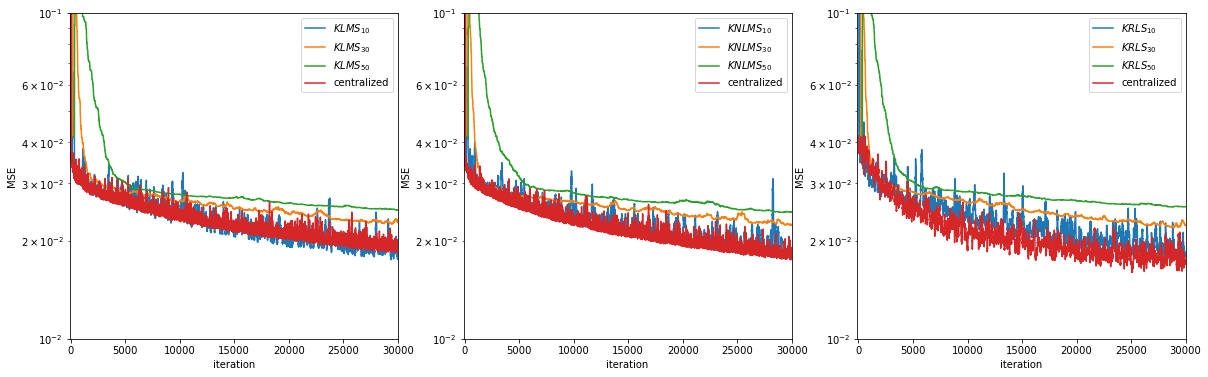

In [392]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1,3,1)
for i in range(len(amse_KLMS)):
    plt.semilogy(range(len(amse_KLMS[i])),amse_KLMS[i],label="$KLMS_{" + str(P[i])+"}$")
# amse_cent = np.convolve(amse_cent,np.ones(200)/200,'valid')    
plt.semilogy(range(len(amse_KLMS_cent)),amse_KLMS_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1,3,2)
for i in range(len(amse_KNLMS)):
    plt.semilogy(range(len(amse_KNLMS[i])),amse_KNLMS[i],label="$KNLMS_{" + str(P[i])+"}$")
# amse_cent = np.convolve(amse_cent,np.ones(200)/200,'valid')    
plt.semilogy(range(len(amse_KNLMS_cent)),amse_KNLMS_cent,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")

plt.subplot(1,3,3)
for i in range(len(amse_KRLS)):
    plt.semilogy(range(len(amse_KRLS[i])),amse_KRLS[i],label="$KRLS_{" + str(P[i])+"}$")
amse_cent_KRLS_smooth = np.convolve(amse_KRLS_cent,np.ones(60)/60,'valid')    
plt.semilogy(range(len(amse_cent_KRLS_smooth)),amse_cent_KRLS_smooth,label="centralized")
plt.legend()
plt.ylim([1e-2,1e-1])
plt.xlim([-100,iteration])
plt.ylabel("MSE")
plt.xlabel("iteration")